In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, identity, kron
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh
from scipy.sparse.linalg import expm

Ground state energy at classical limit (g=0) = -3.0050


g=1.50 | ED E0: -3.0050 | Trotter E0: -6.5024


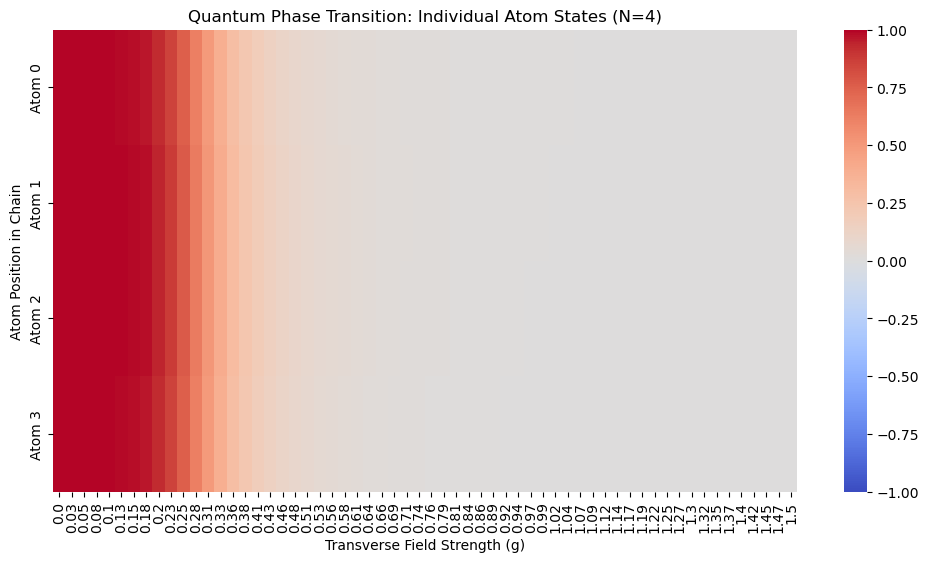

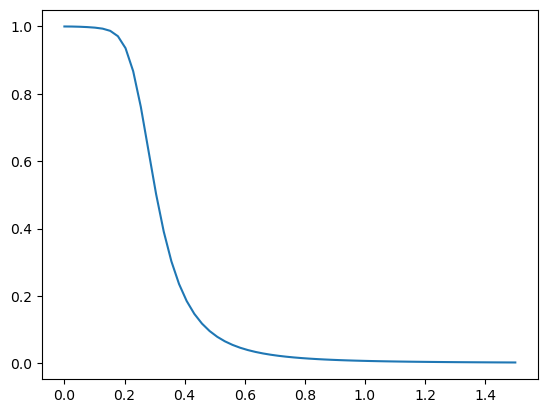

Estimated Critical Point (g_c): 0.2669


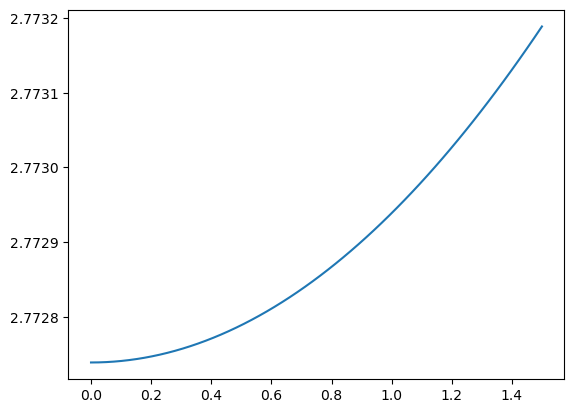

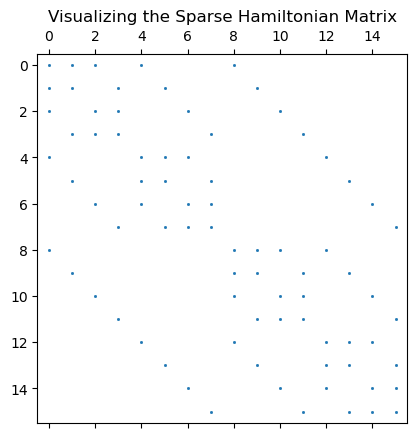

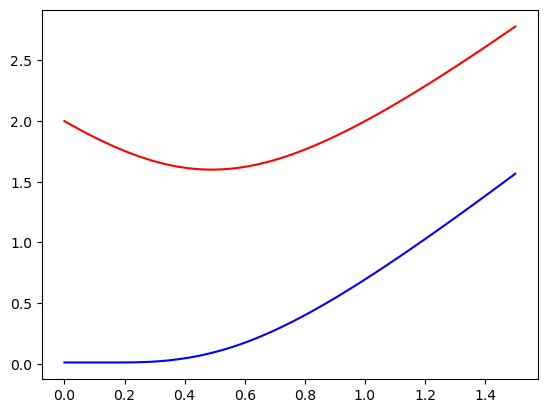

Text(0.5, 1.0, 'State Evolution in Imaginary Time')

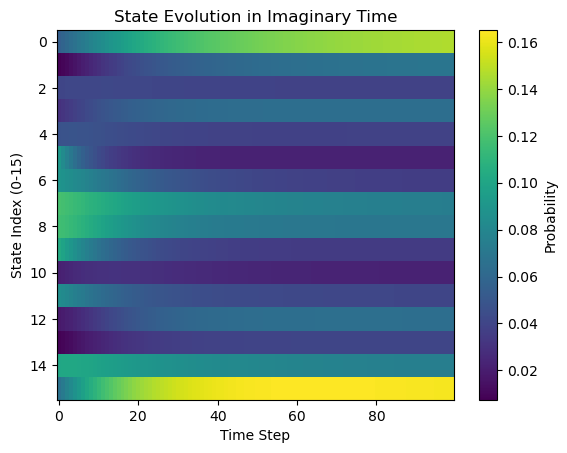

In [6]:
def build_operator(N, op_type, index):
    """Builds an operator (sx or sz) acting on a specific atom index."""
    sz = csr_matrix([[1, 0], [0, -1]])   #defining Pauli matrices
    sx = csr_matrix([[0, 1], [1, 0]])
    I2 = identity(2)
    
    target = sz if op_type == 'sz' else sx     #determines which Pauli amtrix to use on the code 
    op_list = [I2] * N          #creates N copies of the Hamiltonian 
    op_list[index] = target     #picks one of the atoms to act upon with the Pauli matrices
    
    res = op_list[0]
    for j in range(1, N):
        res = kron(res, op_list[j], format='csr') #performs a tensor product operation on all matrices, initialised with op_list[0]
    return res

def build_zz(N, i, j):   #defines the interaction terms between two atoms, 
    sz = csr_matrix([[1, 0], [0, -1]])
    I2 = identity(2)

    ops = [I2] * N
    ops[i] = sz
    ops[j] = sz

    res = ops[0]
    for k in range(1, N):
        res = kron(res, ops[k], format='csr')

    return res

def build_hamiltonian(N, J, g):
    dim = 2**N
    H = csr_matrix((dim, dim))
    # Field Term (X-direction)
    for i in range(N):
        H -= g * build_operator(N, 'sx', i)
    #Interaction Term (Z-direction)
    for i in range(N-1):
        H -= J * build_zz(N, i, i+1)
    # PINNING FIELD: Add a tiny bit of Z-field to the first atom 
    # This prevents the "stripey" random flipping between Red and Blue.
    H -= initialisation * build_operator(N, 'sz', 0)
    
    return H


N = 4       # Number of atoms
J = 1  # Coupling strength
beta = 0.01  #temperature parameter 
trotter_value = 1.5
initialisation = 0.005
g_values = np.linspace(0,1.5 ,60)
all_atom_data = []
m_plot_data = []
partition_functions = []
gaps_plot_data1 = []
gaps_plot_data2 = []
history = []

tau_total = 1 # Total "imaginary time" (higher is more accurate/colder)
steps = 100       # Number of Trotter slices
d_tau = tau_total / steps

for g in g_values:

    H = build_hamiltonian(N, J, g)
    if np.isclose(g, 0): 
        energy_val, _ = eigsh(H, k=1, which='SA')
        gs_energy = energy_val[0]
        print(f"Ground state energy at classical limit (g=0) = {gs_energy:.4f}")

    eigvals = eigh(H.toarray(), eigvals_only=True)
    gap1 = eigvals[2] - eigvals[0]
    gaps_plot_data1.append(gap1)
    gap2 = eigvals[1] - eigvals[0]
    gaps_plot_data2.append(gap2)
    # this code calculates the partition function for varying values of the transverse field, g
    # Complete full diagonalization to get all energy levels
    all_energies = eigh(H.toarray(), eigvals_only=True)

    # --- TROTTER METHOD START ---
    if np.isclose(g, trotter_value, atol = 0.01):
        
        # 1. Build the FULL Interaction Matrix (Sum of all ZZ terms)
        dim = 2**N
        H_int = csr_matrix((dim, dim))
        for i in range(N-1):
            H_int -= J * build_zz(N, i, i+1)
        
        # 2. Build the FULL Field Matrix (Sum of all X terms)
        H_field = csr_matrix((dim, dim))
        for i in range(N):
            H_field -= g * build_operator(N, 'sx', i)

        # 3. Create the Trotter Gates
        gate_int = expm(-d_tau * H_int.toarray())
        gate_field = expm(-d_tau * H_field.toarray())
    
        # Start with a random state
        psi_trotter = np.random.rand(2**N) + 1j*np.random.rand(2**N)
        psi_trotter /= np.linalg.norm(psi_trotter)
    
        # Apply the Trotter steps
        for _ in range(steps):
            psi_trotter = gate_int @ psi_trotter
            psi_trotter = gate_field @ psi_trotter
            psi_trotter /= np.linalg.norm(psi_trotter) 
            history.append(np.abs(psi_trotter)**2)
        
        # Calculate Energy
        e0_trotter = np.vdot(psi_trotter, H @ psi_trotter).real

        
        
        # Use E_min from your eigh results for the print statement
        print(f"g={g:.2f} | ED E0: {gs_energy:.4f} | Trotter E0: {e0_trotter:.4f}")

    ###### END TROTTER METHOD 
    
    # Calculate the actual lnZ
    E_min = np.min(all_energies)
    Z_shifted = np.sum(np.exp(-beta * (all_energies - E_min)))
    actual_lnZ = np.log(Z_shifted) - (beta * E_min)

    
    partition_functions.append(actual_lnZ) 

    # Get the ground state 
    energy, states = eigsh(H, k=1, which='SA')
    psi = states[:, 0]
    # psi = psi / np.linalg.norm(psi)
    
    # Calculate <Sz> for EACH of the 8 atoms
    current_g_step_spins = []
    for i in range(N):
        sz_op = build_operator(N, 'sz', i)
        # Expectation value: <psi|Sz|psi>
        expectation = np.vdot(psi, sz_op.dot(psi)).real
        current_g_step_spins.append(expectation)

    all_atom_data.append(current_g_step_spins)
            # 1. Average the spins of all N atoms for this specific g
    magnetization = np.mean(current_g_step_spins)
    
    # 2. Store it in a new list (you'll need to initialize 'm_plot_data = []' outside the loop)
    m_plot_data.append(magnetization)


plt.figure(figsize=(12, 6))

sns.heatmap(np.array(all_atom_data).T, 
            xticklabels=np.round(g_values, 2), 
            yticklabels=[f"Atom {i}" for i in range(N)],
            cmap='coolwarm', vmin=-1, vmax=1, center=0)

plt.title(f"Quantum Phase Transition: Individual Atom States (N={N})")
plt.xlabel("Transverse Field Strength (g)")
plt.ylabel("Atom Position in Chain")
plt.show()

plt.plot(g_values, m_plot_data)
plt.show()

dM_dg = np.abs(np.diff(m_plot_data) / np.diff(g_values))

# 2. Find the index of the maximum slope
# np.argmax gives us the index where the drop is steepest
max_slope_idx = np.argmax(dM_dg)

# 3. Extract the critical g value
# We use the midpoint between the two g-values where the diff was taken
g_critical = (g_values[max_slope_idx] + g_values[max_slope_idx + 1]) / 2

print(f"Estimated Critical Point (g_c): {g_critical:.4f}")

plt.plot(g_values, partition_functions)
plt.show()

plt.spy(H, markersize=1)
plt.title("Visualizing the Sparse Hamiltonian Matrix")
plt.show()

plt.plot(g_values, gaps_plot_data1, c = 'red')
plt.plot(g_values, gaps_plot_data2, c = 'blue')
plt.show()

plt.imshow(np.array(history).T, aspect='auto', cmap='viridis')
plt.colorbar(label='Probability')
plt.xlabel('Time Step')
plt.ylabel('State Index (0-15)')
plt.title('State Evolution in Imaginary Time')


Validation steps: 

The switch of magentization should occur at g=1 for an infinite chain, but becasue there is a high proportion of atoms on the edge of the chain, the energy per spin is a lot less. These atoms only have one bond, making the transfer point of the crossover lower than one. As the system size increases, the critical point gets closer and closer to occurring when g = 1, J = 1. 

We have validated that the ground state energy (in absence of the g field) equals -(N-1)J. 

Research into different values of beta and the effect they have on the Z value. Note at high temperatures the partition function is pretty constant, but as the temperature decreases the physics becomes more interesting... 

quantum phase transition at a critical point... 


Starting TFIM computation with N=8, 60 g-values
Matrix dimension: 256×256
Estimated runtime: 1-3 seconds

Progress: 0/60
  Ground state energy at g=0: -8.0010
Progress: 10/60
Progress: 20/60
Progress: 30/60
Progress: 40/60
Progress: 50/60
  Running Trotter evolution at g=1.500
    Trotter E0: -13.1971 | ED E0: -13.3850

Completed! Now plotting...



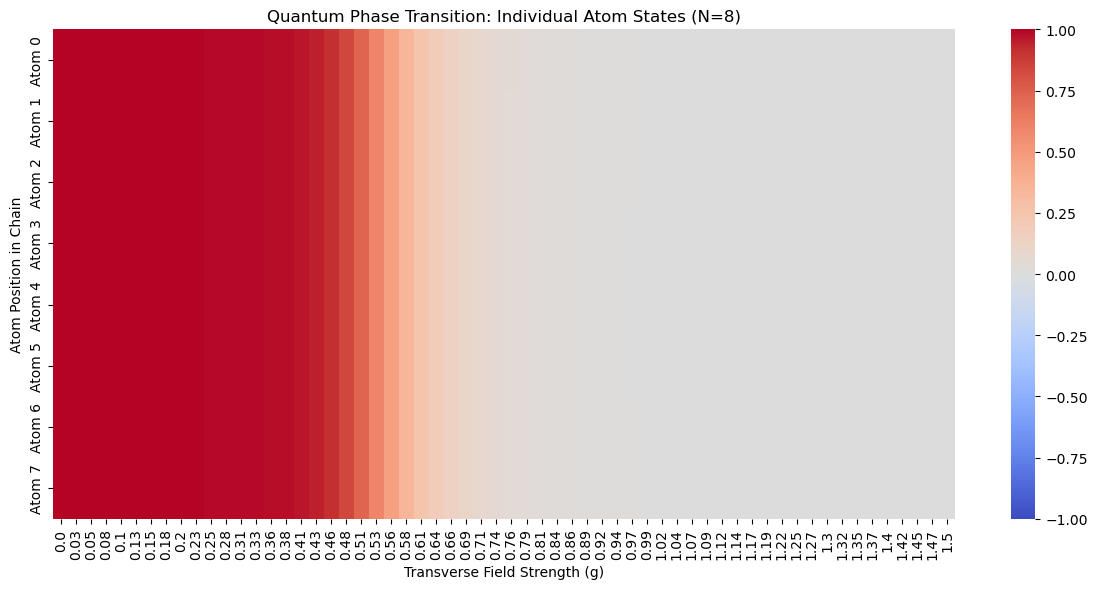

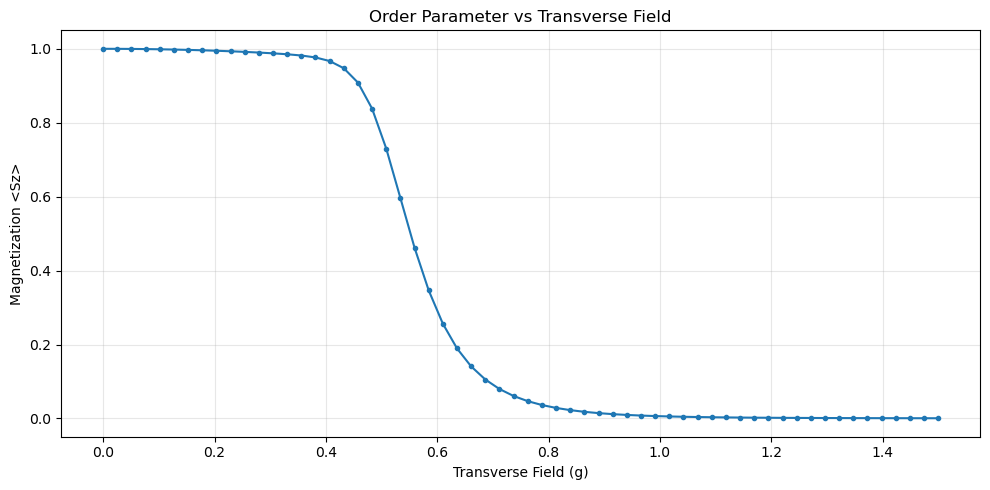

Estimated Critical Point from dM/dg (g_c): 0.5466


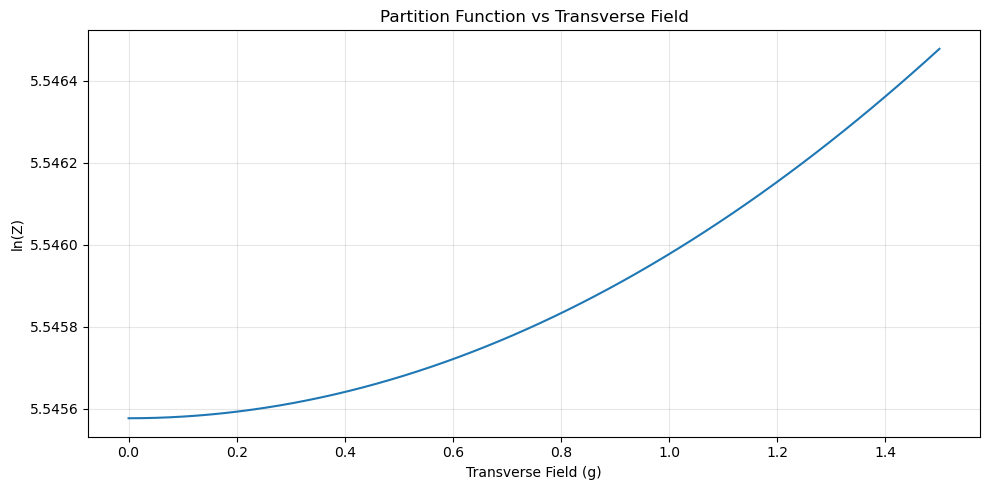

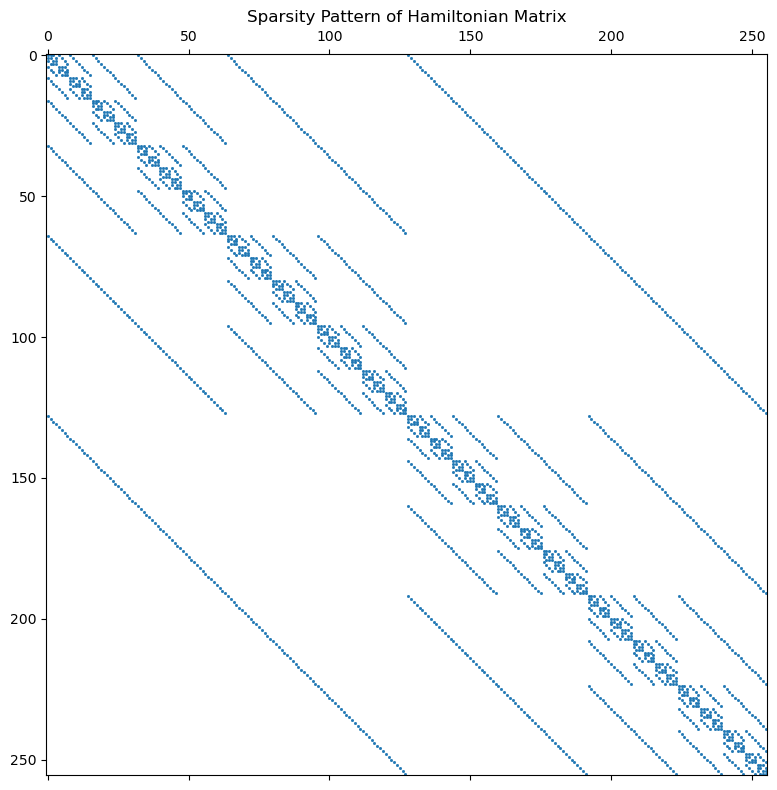

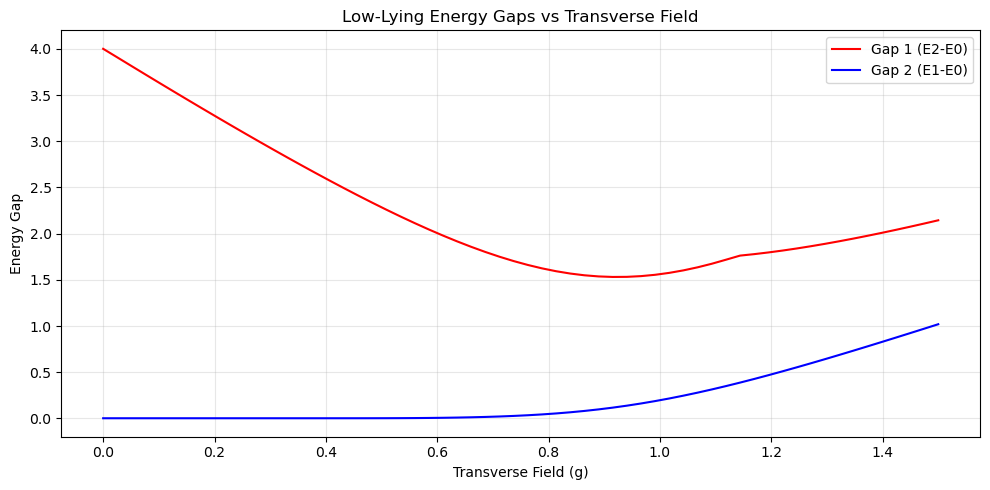

Estimated pseudo-critical point from d²E0/dg²: g ≈ 0.8898


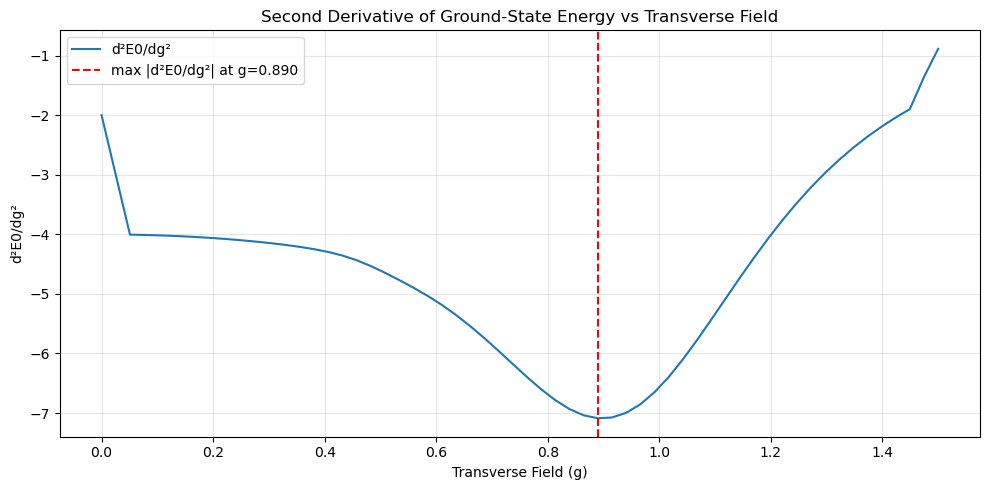

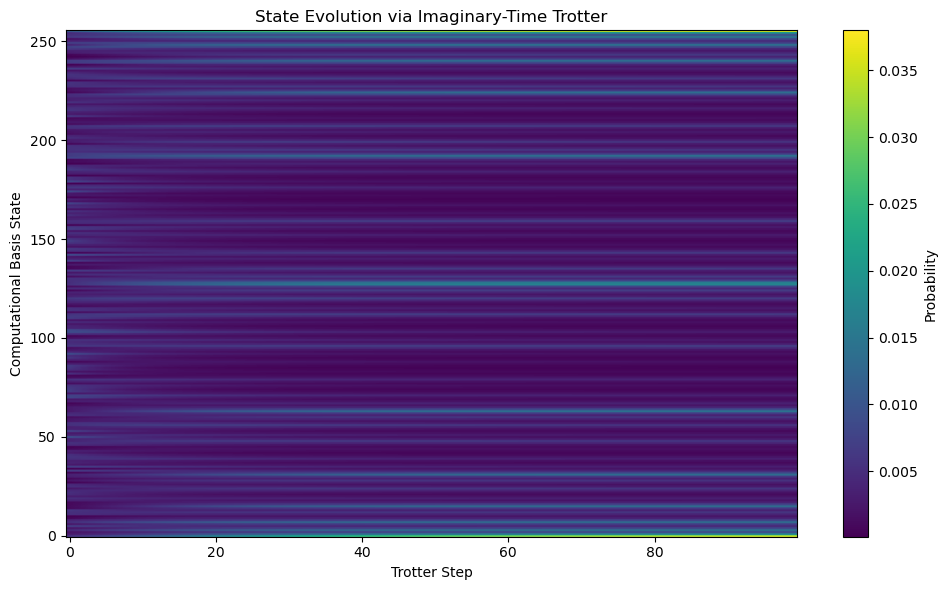


EXECUTION TIME SUMMARY

build_hamiltonian                       
  Total:    9.500 s  |  Calls:    61  |  Avg/call:   0.1557 s  |   33.2%
build_operator                          
  Total:    9.401 s  |  Calls:  1037  |  Avg/call:   0.0091 s  |   32.8%
compute_observables                     
  Total:    4.343 s  |  Calls:    60  |  Avg/call:   0.0724 s  |   15.2%
build_zz                                
  Total:    4.113 s  |  Calls:   495  |  Avg/call:   0.0083 s  |   14.4%
eigendecomposition                      
  Total:    1.190 s  |  Calls:   121  |  Avg/call:   0.0098 s  |    4.2%
trotter_evolution                       
  Total:    0.084 s  |  Calls:     1  |  Avg/call:   0.0843 s  |    0.3%

----------------------------------------------------------------------
TOTAL                                   :   28.632 s



In [ ]:
# Instrumented version of your TFIM code with computation counter
# Add this at the top of your script to track actual runtime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, identity, kron
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh, expm
import time
from functools import wraps


# ============================================================================
# COMPUTATION COUNTER CLASS
# ============================================================================


class ComputationTimer:
    """Tracks time spent in different parts of the computation."""
    
    def __init__(self):
        self.timings = {}
        self.call_counts = {}
    
    def timer(self, name):
        """Decorator to time a function."""
        def decorator(func):
            @wraps(func)
            def wrapper(*args, **kwargs):
                if name not in self.timings:
                    self.timings[name] = 0
                    self.call_counts[name] = 0
                
                start = time.perf_counter()
                result = func(*args, **kwargs)
                elapsed = time.perf_counter() - start
                
                self.timings[name] += elapsed
                self.call_counts[name] += 1
                
                return result
            return wrapper
        return decorator
    
    def print_summary(self):
        """Print timing breakdown."""
        print("\n" + "="*70)
        print("EXECUTION TIME SUMMARY")
        print("="*70 + "\n")
        
        total_time = sum(self.timings.values())
        
        for name in sorted(self.timings.keys(), 
                          key=lambda x: self.timings[x], 
                          reverse=True):
            t = self.timings[name]
            count = self.call_counts[name]
            pct = 100 * t / total_time if total_time > 0 else 0
            avg_per_call = t / count if count > 0 else 0
            
            print(f"{name:40s}")
            print(f"  Total: {t:8.3f} s  |  Calls: {count:5d}  |  Avg/call: {avg_per_call:8.4f} s  |  {pct:5.1f}%")
        
        print("\n" + "-"*70)
        print(f"{'TOTAL':40s}: {total_time:8.3f} s")
        print("="*70 + "\n")


# Global timer instance
timer = ComputationTimer()


# ============================================================================
# ORIGINAL FUNCTIONS WITH TIMING DECORATORS
# ============================================================================


@timer.timer("build_operator")
def build_operator(N, op_type, index):
    """Builds an operator (sx or sz) acting on a specific atom index."""
    sz = csr_matrix([[1, 0], [0, -1]])
    sx = csr_matrix([[0, 1], [1, 0]])
    I2 = identity(2)
    
    target = sz if op_type == 'sz' else sx
    op_list = [I2] * N
    op_list[index] = target
    
    res = op_list[0]
    for j in range(1, N):
        res = kron(res, op_list[j], format='csr')
    return res



@timer.timer("build_zz")
def build_zz(N, i, j):
    """Defines the interaction terms between two atoms."""
    sz = csr_matrix([[1, 0], [0, -1]])
    I2 = identity(2)
    
    ops = [I2] * N
    ops[i] = sz
    ops[j] = sz
    
    res = ops[0]
    for k in range(1, N):
        res = kron(res, ops[k], format='csr')
    
    return res



@timer.timer("build_hamiltonian")
def build_hamiltonian(N, J, g, initialisation=0.005):
    dim = 2**N
    H = csr_matrix((dim, dim))
    
    # Field Term (X-direction)
    for i in range(N):
        H -= g * build_operator(N, 'sx', i)
    
    # Interaction Term (Z-direction)
    for i in range(N):
        H -= J * build_zz(N, i, (i+1)%N)
    
    # PINNING FIELD
    H -= initialisation * build_operator(N, 'sz', 0)
    
    return H



@timer.timer("eigendecomposition")
def compute_eigendecomposition(H, full=False):
    """Compute eigenvalues/eigenvectors."""
    if full:
        # Full spectrum (dense)
        eigvals = eigh(H.toarray(), eigvals_only=True)
        return eigvals, None
    else:
        # Ground state (sparse)
        energy, states = eigsh(H, k=1, which='SA')
        return energy, states



@timer.timer("compute_observables")
def compute_ground_state_observables(N, psi, op_type='sz'):
    """Compute <Sz_i> or <Sx_i> for all atoms."""
    observables = []
    for i in range(N):
        op = build_operator(N, op_type, i)
        expectation = np.vdot(psi, op.dot(psi)).real
        observables.append(expectation)
    return observables



@timer.timer("trotter_evolution")
def perform_trotter_evolution(H, H_int, H_field, N, d_tau, steps):
    """Perform imaginary-time Trotter evolution."""
    dim = 2**N
    
    # Create gates
    gate_int = expm(-d_tau * H_int.toarray())
    gate_field = expm(-d_tau * H_field.toarray())
    
    # Random initial state
    psi = np.random.rand(dim) + 1j * np.random.rand(dim)
    psi /= np.linalg.norm(psi)
    
    history = []
    
    # Evolve
    for _ in range(steps):
        psi = gate_int @ psi
        psi = gate_field @ psi
        psi /= np.linalg.norm(psi)
        history.append(np.abs(psi)**2)
    
    # Final energy
    energy = np.vdot(psi, H @ psi).real
    
    return psi, energy, history



# ============================================================================
# MAIN COMPUTATION WITH TIMING
# ============================================================================


def run_tfim_computation():
    """Main TFIM computation with detailed timing."""
    
    # Parameters
    N = 8
    J = 1
    beta = 0.01
    trotter_value = 1.5
    initialisation = 0.005
    g_values = np.linspace(0, 1.5, 60)
    
    tau_total = 1
    steps = 100
    d_tau = tau_total / steps
    
    # Storage
    all_atom_data = []
    m_plot_data = []
    partition_functions = []
    gaps_plot_data1 = []
    gaps_plot_data2 = []
    ground_state_energies = []      ### NEW: store E0(g)
    history = []
    gs_energy = None
    
    print(f"\nStarting TFIM computation with N={N}, {len(g_values)} g-values")
    print(f"Matrix dimension: {2**N}×{2**N}")
    print(f"Estimated runtime: 1-3 seconds\n")
    
    # Main loop
    for idx, g in enumerate(g_values):
        if idx % 10 == 0:
            print(f"Progress: {idx}/{len(g_values)}")
        
        # Build Hamiltonian
        H = build_hamiltonian(N, J, g, initialisation)
        
        # Classical limit
        if np.isclose(g, 0):
            energy_val, _ = compute_eigendecomposition(H, full=False)
            gs_energy = energy_val[0]
            print(f"  Ground state energy at g=0: {gs_energy:.4f}")
        
        # Get spectrum
        eigvals, _ = compute_eigendecomposition(H, full=True)
        
        # Gaps
        gap1 = eigvals[2] - eigvals[0]
        gaps_plot_data1.append(gap1)
        gap2 = eigvals[1] - eigvals[0]
        gaps_plot_data2.append(gap2)
        
        # Partition function
        all_energies = eigvals
        E_min = np.min(all_energies)
        Z_shifted = np.sum(np.exp(-beta * (all_energies - E_min)))
        actual_lnZ = np.log(Z_shifted) - (beta * E_min)
        partition_functions.append(actual_lnZ)
        
        # Ground state and observables
        energy, states = compute_eigendecomposition(H, full=False)
        psi = states[:, 0]
        
        # Store ground-state energy E0(g)
        ground_state_energies.append(energy[0])   ### NEW
        
        current_g_step_spins = compute_ground_state_observables(N, psi, op_type='sz')
        all_atom_data.append(current_g_step_spins)
        
        magnetization = np.mean(current_g_step_spins)
        m_plot_data.append(magnetization)
        
        # Trotter at specific g
        if np.isclose(g, trotter_value, atol=0.01):
            print(f"  Running Trotter evolution at g={g:.3f}")
            
            # Build split Hamiltonians
            dim = 2**N
            H_int = csr_matrix((dim, dim))
            for i in range(N-1):
                H_int -= J * build_zz(N, i, i+1)
            
            H_field = csr_matrix((dim, dim))
            for i in range(N):
                H_field -= g * build_operator(N, 'sx', i)
            
            psi_t, e0_t, hist = perform_trotter_evolution(
                H, H_int, H_field, N, d_tau, steps
            )
            history.extend(hist)
            print(f"    Trotter E0: {e0_t:.4f} | ED E0: {energy[0]:.4f}")
    
    print(f"\nCompleted! Now plotting...\n")
    
    ground_state_energies = np.array(ground_state_energies)   ### NEW
    
    # Plot 1: Heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(np.array(all_atom_data).T,
                xticklabels=np.round(g_values, 2),
                yticklabels=[f"Atom {i}" for i in range(N)],
                cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f"Quantum Phase Transition: Individual Atom States (N={N})")
    plt.xlabel("Transverse Field Strength (g)")
    plt.ylabel("Atom Position in Chain")
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Magnetization
    plt.figure(figsize=(10, 5))
    plt.plot(g_values, m_plot_data, marker='o', markersize=3)
    plt.xlabel("Transverse Field (g)")
    plt.ylabel("Magnetization <Sz>")
    plt.title("Order Parameter vs Transverse Field")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Critical point estimate from dM/dg
    dM_dg = np.abs(np.diff(m_plot_data) / np.diff(g_values))
    max_slope_idx = np.argmax(dM_dg)
    g_critical = (g_values[max_slope_idx] + g_values[max_slope_idx + 1]) / 2
    print(f"Estimated Critical Point from dM/dg (g_c): {g_critical:.4f}")
    
    # Plot 4: Partition function
    plt.figure(figsize=(10, 5))
    plt.plot(g_values, partition_functions)
    plt.xlabel("Transverse Field (g)")
    plt.ylabel("ln(Z)")
    plt.title("Partition Function vs Transverse Field")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 5: Hamiltonian sparsity
    H_example = build_hamiltonian(N, J, 1.0, initialisation)
    plt.figure(figsize=(8, 8))
    plt.spy(H_example, markersize=1)
    plt.title("Sparsity Pattern of Hamiltonian Matrix")
    plt.tight_layout()
    plt.show()
    
    # Plot 6: Energy gaps
    plt.figure(figsize=(10, 5))
    plt.plot(g_values, gaps_plot_data1, c='red', label='Gap 1 (E2-E0)')
    plt.plot(g_values, gaps_plot_data2, c='blue', label='Gap 2 (E1-E0)')
    plt.xlabel("Transverse Field (g)")
    plt.ylabel("Energy Gap")
    plt.title("Low-Lying Energy Gaps vs Transverse Field")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # --- NEW: Plot 7: Second derivative of ground-state energy E0(g) ---
    # Use central finite differences via np.gradient twice
    dE_dg = np.gradient(ground_state_energies, g_values)
    d2E_dg2 = np.gradient(dE_dg, g_values)
    
    # Locate pseudo-critical point from max |d²E0/dg²|
    idx_max = np.argmax(np.abs(d2E_dg2))
    g_crit_E0 = g_values[idx_max]
    print(f"Estimated pseudo-critical point from d²E0/dg²: g ≈ {g_crit_E0:.4f}")
    
    plt.figure(figsize=(10, 5))
    plt.plot(g_values, d2E_dg2, label='d²E0/dg²')
    plt.axvline(g_crit_E0, color='r', linestyle='--', 
                label=f'max |d²E0/dg²| at g={g_crit_E0:.3f}')
    plt.xlabel("Transverse Field (g)")
    plt.ylabel("d²E0/dg²")
    plt.title("Second Derivative of Ground-State Energy vs Transverse Field")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot 8: Trotter state evolution
    if history:
        plt.figure(figsize=(10, 6))
        plt.imshow(np.array(history).T, aspect='auto', cmap='viridis', origin='lower')
        plt.colorbar(label='Probability')
        plt.xlabel('Trotter Step')
        plt.ylabel('Computational Basis State')
        plt.title('State Evolution via Imaginary-Time Trotter')
        plt.tight_layout()
        plt.show()
    
    return {
        'all_atom_data': all_atom_data,
        'm_plot_data': m_plot_data,
        'partition_functions': partition_functions,
        'gaps_plot_data1': gaps_plot_data1,
        'gaps_plot_data2': gaps_plot_data2,
        'g_critical_magnetization': g_critical,
        'g_critical_E0''': g_crit_E0,
        'g_values': g_values,
        'E0': ground_state_energies,
        'd2E_dg2': d2E_dg2,
    }



if __name__ == "__main__":
    # Run computation
    results = run_tfim_computation()
    
    # Print timing summary
    timer.print_summary()
